<a href="https://colab.research.google.com/github/anilbhatt1/EVA4P1_S15B_Depth_FG_Detection/blob/master/EVA4P1_S15_Comb_FG_Depth_Prediction_BCE_SSIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! nvidia-smi

Sun May 31 07:20:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import seaborn as sns
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
sns.set()

#import albumentations
#print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
#album_version_needed = "0.4.5"
#if albumentations.__version__ != album_version_needed:
#  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)

!pip install kornia
from kornia.losses import SSIM
from kornia.losses import DiceLoss

Pytorch version: 1.5.0+cu101
     |████████████████████████████████| 163kB 1.2MB/s 


### Unzip FG_BG, Mask, Depth and corresponding BG images from gdrive

In [0]:
t1 = time()
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Mask_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Depth_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/BG_and_Its_Flip.zip"
t2 = time()
print(f'FG_BG, Mask & Depth Copy took {(t2-t1)/60:.5f} minutes')

FG_BG, Mask & Depth Copy took 5.67176 minutes


### Copying Log file that contains FG_BG file names, their path in gdrive & corresponding BG file name from which they were made 

In [0]:
if os.path.exists('/content/FG_BG_Filename_withflip_Logs.txt'):
    print('Log file exists')    
else:  
    !cp '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Filename_withflip_Logs.txt' '/content/'
    print('Copied Log File')

Copied Log File


### Copying SRC libraries from Github to Colab.

In [0]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/EVA4P1_S15B_Depth_FG_Detection

Cloning into 'EVA4P1_S15B_Depth_FG_Detection'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 415 (delta 55), reused 0 (delta 0), pack-reused 307
Receiving objects: 100% (415/415), 14.21 MiB | 7.17 MiB/s, done.
Resolving deltas: 100% (198/198), done.


In [0]:
%cd '/content/EVA4P1_S15B_Depth_FG_Detection/src/losses'
! ls

/content/EVA4P1_S15B_Depth_FG_Detection/src/losses
Test1.py  Test.py  Train1.py  Train.py


### Importing modules from Colab data folder to Colab session 

In [0]:
os.chdir('/content/EVA4P1_S15B_Depth_FG_Detection/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import makedata as md
from src.dataset import make1data as md1
from src.dataset import Alb_data_transforms as Alb
from src.models  import S15_FGDepth_models as ntwk
from src.losses  import Train as Train
from src.losses  import Test  as Test
from src.losses  import Train1 as Train1
from src.losses  import Test1  as Test1
from src.utils   import Freeze_Layers as Freeze

### Creating a list - content_list for FG_BG log file. This content_list will be used to create dataloader to pick-up input images randomly for both training and testing

In [0]:
log_fg_bg = open('/content/FG_BG_Filename_withflip_Logs.txt',"r")
content_list = log_fg_bg.readlines()
print('No: of records in log_fg_bg:',len(content_list))
print(content_list[0])
log_fg_bg.close()

data_root = Path('/content')
f1, f2, f3, f4 = data_root/'FG_BG_400K', data_root/'BG_and_Its_Flip', data_root/'FG_BG_Mask_400K',  \
                 data_root/'FG_BG_Depth_0_400K'

No: of records in log_fg_bg: 400000
Img_fg_bg_1.jpg,Img21.jpg,Image41.png,(192, 192, 108, 156, 51, 3, 159, 3, 51, 159, 159, 159)



In [0]:
bs_small  = 96
bs_medium = 96
bs_large  = 16
bs_test   = 96
bs_display= 8
rows = 5
img_save, model_save = 1500, 500
t0k, t10k, t80k, t160k, t220k, t260k, t280k, t360k, t390k, t400k  = 0, 10000, 80000, 160000, 220000,\
                                                                             260000, 280000, 360000,\
                                                                                     390000, 400000

### Creating tranforms. For test data, GT mask & GT depth only 'To Tensor' & 'Resize' is used.

In [0]:
import albumentations as A
lst = [(64,64),(96,96),(192,192)]
fg_bg_mean, fg_bg_stdev                    = [0.56670278, 0.49779153, 0.43632878], [0.25049532, 0.2468085, 0.25520498]
mask_mean,  mask_stdev                     = [0.20249742], [0.20249742]
depth_mean, depth_stdev                    = [0.32939295], [0.24930712]
bg_mean, bg_stdev                          = [0.58245822, 0.51269352, 0.43691653], [0.24252189, 0.24318804, 0.25401604]
fg_bg_transforms, bg_transforms, mask_transforms, depth_transforms = {}, {}, {}, {}
test_fg_bg_transforms, test_bg_transforms                          = {}, {}
for i in range(len(lst)):
    ht, wd = lst[i]
    cut_out_size = int(ht/4)
    fg_bg_transforms["t_{0}".format(i)] = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.IAAAdditiveGaussianNoise(),
                                                                     A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                     #A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev),
                                                                     A.Cutout(num_holes=1,max_h_size=cut_out_size,max_w_size=cut_out_size),])
    bg_transforms["t_{0}".format(i)]    = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.IAAAdditiveGaussianNoise(),
                                                                     A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),])
                                                                     #A.Normalize(mean=bg_mean, std=bg_stdev),])
    mask_transforms["t_{0}".format(i)]  = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                     #A.Normalize(mean=mask_mean, std=mask_stdev),])
    depth_transforms["t_{0}".format(i)] = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                     #A.Normalize(mean=depth_mean, std=depth_stdev),])
    test_fg_bg_transforms["t_{0}" .format(i)]  = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                              #A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev),])
    test_bg_transforms["t_{0}" .format(i)]        = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                              #A.Normalize(mean=bg_mean, std=bg_stdev),])

In [0]:
print(fg_bg_transforms)
print(bg_transforms)
print(mask_transforms)
print(depth_transforms)
print(test_fg_bg_transforms)
print(test_bg_transforms)

{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f03ff2e5d30>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f03ff2ea518>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f03ff2eacc0>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f03ff2e5eb8>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f03ff2ea6a0>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f03ff2eae48>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f03ff2e5fd0>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f03ff2ea7b8>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f03ff2eaf60>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f03ff2ea128>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0

### Creating dataloader using content_list. Since total 280K images are present in training set, 5 cohorts are created to manage the training volume.
- 0 - 80k    -> size 64x64    
- 80k - 160k -> size 64x64    
- 160k -220k -> size 64x64    
- 220k -260k -> size 96x96    
- 260k -280k -> size 192x192  
- 280k -400k -> size 64x64 -> Test dataset

In [0]:
train_ds_mini_1    = md1.Make1data(f1, content_list, t0k, t80k,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_mini_2    = md1.Make1data(f1, content_list, t80k, t160k,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_mini_3    = md1.Make1data(f1, content_list, t160k, t220k,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_medium    = md1.Make1data(f1, content_list, t220k, t260k,  
                             fg_bg_transforms['t_1'],bg_transforms['t_1'],mask_transforms['t_1'],depth_transforms['t_1'])
train_ds_large   = md1.Make1data(f1, content_list, t260k, t280k,  
                             fg_bg_transforms['t_2'],bg_transforms['t_2'],mask_transforms['t_2'],depth_transforms['t_2'])
test_ds          = md1.Make1data(f1, content_list, t280k, t400k,  
                             test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])

In [0]:
train_dl_mini_1  = DataLoader(train_ds_mini_1, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_2  = DataLoader(train_ds_mini_2, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_3  = DataLoader(train_ds_mini_3, batch_size = bs_small,  shuffle = True, pin_memory = True)
train_dl_medium  = DataLoader(train_ds_medium, batch_size = bs_medium, shuffle = True, pin_memory = True)
train_dl_large   = DataLoader(train_ds_large,  batch_size = bs_large, shuffle = True, pin_memory = True)
test_dl          = DataLoader(test_ds,         batch_size = bs_test,  shuffle = True, pin_memory = True)

In [0]:
test_ds_display = md1.Make1data(f1, content_list, t360k, t400k,  
                  test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
test_dl_display = DataLoader(test_ds_display, batch_size = bs_display,  shuffle = True, pin_memory = True)

### To check if batch & sizes are coming correctly & whether dataloader and transforms are working as expected

In [0]:
images_mini_1 = next(iter(train_dl_mini_1))
images_mini_2 = next(iter(train_dl_mini_2))
images_mini_3 = next(iter(train_dl_mini_3))
images_medium = next(iter(train_dl_medium))
images_large  = next(iter(train_dl_large))
images_test   = next(iter(test_dl))

In [0]:
print('B1:',[(k, v.shape) for k, v in images_mini_1.items()])
print('B2:',[(k, v.shape) for k, v in images_mini_2.items()])
print('B3:',[(k, v.shape) for k, v in images_mini_3.items()])
print('B4:',[(k, v.shape) for k, v in images_medium.items()])
print('B5:',[(k, v.shape) for k, v in images_large.items()])
print('B6:',[(k, v.shape) for k, v in images_test.items()])

B1: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B2: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B3: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B4: [('f1', torch.Size([96, 3, 96, 96])), ('f2', torch.Size([96, 3, 96, 96])), ('f3', torch.Size([96, 1, 96, 96])), ('f4', torch.Size([96, 1, 96, 96]))]
B5: [('f1', torch.Size([16, 3, 192, 192])), ('f2', torch.Size([16, 3, 192, 192])), ('f3', torch.Size([16, 1, 192, 192])), ('f4', torch.Size([16, 1, 192, 192]))]
B6: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]


### To display images created out of dataloader & transform to ensure images are coming out for display correctly

In [0]:
imgs = images_large['f1']

In [0]:
def show(tensors, figsize= (10,10), *args, **kwargs):
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

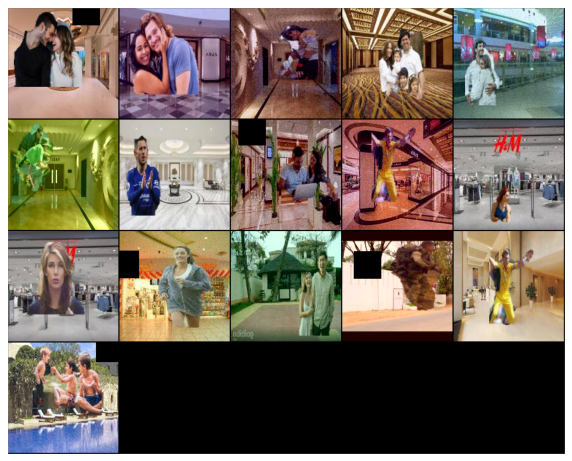

In [0]:
show(imgs, nrow=rows)

### Initializing the model and assigning it to Cuda

In [0]:
model = ntwk.FGDepth()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

FGDepth(
  (convA): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convB): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convC): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convD): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (convE): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (blck1): DownSize(
  

### Defining Freeze class. We are using transfer learning & hence this class will be used to freeze the layers as required.

In [0]:
freezer = Freeze.Freezer()

### Defining Loss Criterion & creating scheduler

In [0]:
criterion1  = nn.BCEWithLogitsLoss()
#criterion1  = DiceLoss()
kernel_size = 3
#criterion1  = SSIM(kernel_size, reduction = 'mean')
criterion2  = SSIM(kernel_size, reduction = 'mean')

optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay = 1e-5)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=2, gamma=0.1)

### Defining train & test loss classes

In [0]:
train_loss_fn = Train1.Training_loss1()
test_loss_fn  = Test1.Testing_loss1()

### Reloading model from last saved weights that are present in gdrive

In [0]:
path = f'/content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
path_name       = '/content/gdrive/My Drive/plots_0531_V19A/'
path_model_save = f'/content/gdrive/My Drive/FG_Depth_Prediction_0531V19A.pt'

file_name  = 'train_log.txt'
log_file    = open(f'{path_name}{file_name}','w')
log_file.close()
file_name  = 'test_log.txt'
log_file   = open(f'{path_name}{file_name}','w') 
log_file.close()    

### Train & Test the model

In [0]:
train_loss_all, train_mask_loss_all, train_depth_loss_all, train_mask_iou_all, train_depth_iou_all = [], [], [], [], []
test_loss_all,  test_mask_loss_all,  test_depth_loss_all,  test_mask_iou_all,  test_depth_iou_all  = [], [], [], [], []

for epoch in range(1,5):
  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = 0, 0, 0, 0, 0
  test_loss,  test_mask_loss,  test_depth_loss,  test_mask_iou,  test_depth_iou  = 0, 0, 0, 0, 0
  if epoch < 2:
     batch_size, loader = bs_small, train_dl_mini_1
     freezer.freeze_mask_layers(model)
  elif epoch < 3:
     batch_size, loader  = bs_small, train_dl_mini_2
     freezer.freeze_mask_layers(model)    
  elif epoch < 4:
     batch_size, loader = bs_small,  train_dl_mini_1
     freezer.freeze_depth_layers(model)
  elif epoch < 5:
     batch_size, loader  = bs_small, train_dl_mini_2
     freezer.freeze_depth_layers(model)    

  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc( \
                                                           model, model.device, loader,\
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  batch_size, loader = bs_display, test_dl_display
  test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(             \
                                                         model, model.device, loader, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,         \
                                                         scheduler, img_save)
  scheduler.step()

  train_loss_all.append(train_loss.item()), train_mask_loss_all.append(train_mask_loss.item()), train_depth_loss_all.append(train_depth_loss.item())
  test_loss_all.append(test_loss.item()),   test_mask_loss_all.append(test_mask_loss.item()),   test_depth_loss_all.append(test_depth_loss.item())
  train_mask_iou_all.append(train_mask_iou), train_depth_iou_all.append(train_depth_iou)
  test_mask_iou_all.append(test_mask_iou),   test_depth_iou_all.append(test_depth_iou)

  gc.collect()

  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Mask Layers


TR1|0|0.278|0.150|0.434|0.254:   0%|          | 0/834 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 0 [0/80000 (0%)]	Loss:0.70469 Mask_Loss:0.27758 Dpth_Loss:0.14954 Mask_IOU:0.43418 Dpth_IOU: 0.25437


TR1|0|0.278|0.150|0.434|0.254:   0%|          | 1/834 [00:03<48:16,  3.48s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0531V19A.pt Epoch & Batch-ID: 1 0


TR1|500|0.255|0.107|0.452|0.612:  60%|██████    | 501/834 [10:19<07:46,  1.40s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0531V19A.pt Epoch & Batch-ID: 1 500


TR1|832|0.274|0.105|0.432|0.641: 100%|█████████▉| 832/834 [17:04<00:02,  1.24s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.65439 Mask_Loss:0.27448 Dpth_Loss:0.10543 Mask_IOU:0.43192 Dpth_IOU: 0.64068


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR1|833|0.258|0.106|0.437|0.605: 100%|██████████| 834/834 [17:06<00:00,  1.23s/it]
TS1|0|0.182|0.104|0.585|0.588:   0%|          | 0/5000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [0/40000 (0%)]	Test_Loss: 0.468419 Mask_Loss: 0.18212 Dpth_Loss: 0.10419 Mask_IOU: 0.58513 Dpth_IOU: 0.58822


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|1500|0.201|0.092|0.537|0.701:  30%|███       | 1500/5000 [02:53<06:37,  8.81it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [6000/40000 (30%)]	Test_Loss: 0.493352 Mask_Loss: 0.20051 Dpth_Loss: 0.09233 Mask_IOU: 0.53743 Dpth_IOU: 0.70137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|3000|0.190|0.116|0.626|0.557:  60%|██████    | 3000/5000 [05:46<04:15,  7.83it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [12000/40000 (60%)]	Test_Loss: 0.495918 Mask_Loss: 0.18972 Dpth_Loss: 0.11648 Mask_IOU: 0.62572 Dpth_IOU: 0.55675


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|4500|0.202|0.104|0.538|0.522:  90%|█████████ | 4500/5000 [08:39<01:01,  8.14it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [18000/40000 (90%)]	Test_Loss: 0.507156 Mask_Loss: 0.20180 Dpth_Loss: 0.10356 Mask_IOU: 0.53844 Dpth_IOU: 0.52222


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|4999|0.209|0.088|0.496|0.597: 100%|█████████▉| 4999/5000 [09:37<00:00,  8.74it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [19996/40000 (100%)]	Test_Loss: 0.505281 Mask_Loss: 0.20860 Dpth_Loss: 0.08809 Mask_IOU: 0.49560 Dpth_IOU: 0.59691


TS1|4999|0.209|0.088|0.496|0.597: 100%|██████████| 5000/5000 [09:38<00:00,  8.64it/s]
  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Mask Layers


TR2|0|0.275|0.111|0.441|0.619:   0%|          | 0/834 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 0 [0/80000 (0%)]	Loss:0.66204 Mask_Loss:0.27532 Dpth_Loss:0.11140 Mask_IOU:0.44113 Dpth_IOU: 0.61899


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR2|0|0.275|0.111|0.441|0.619:   0%|          | 1/834 [00:03<44:28,  3.20s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0531V19A.pt Epoch & Batch-ID: 2 0


TR2|500|0.254|0.108|0.454|0.626:  60%|██████    | 501/834 [10:08<07:42,  1.39s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0531V19A.pt Epoch & Batch-ID: 2 500


TR2|832|0.254|0.103|0.464|0.622: 100%|█████████▉| 832/834 [16:49<00:02,  1.21s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.61004 Mask_Loss:0.25364 Dpth_Loss:0.10277 Mask_IOU:0.46407 Dpth_IOU: 0.62236


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR2|833|0.266|0.105|0.454|0.586: 100%|██████████| 834/834 [16:52<00:00,  1.21s/it]
TS2|0|0.194|0.099|0.545|0.601:   0%|          | 0/5000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [0/40000 (0%)]	Test_Loss: 0.487636 Mask_Loss: 0.19443 Dpth_Loss: 0.09878 Mask_IOU: 0.54543 Dpth_IOU: 0.60134


TS2|1500|0.176|0.094|0.569|0.503:  30%|███       | 1500/5000 [02:21<05:23, 10.83it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [6000/40000 (30%)]	Test_Loss: 0.446295 Mask_Loss: 0.17616 Dpth_Loss: 0.09397 Mask_IOU: 0.56943 Dpth_IOU: 0.50251


TS2|3000|0.279|0.106|0.460|0.547:  60%|██████    | 3000/5000 [04:41<03:05, 10.79it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [12000/40000 (60%)]	Test_Loss: 0.664890 Mask_Loss: 0.27931 Dpth_Loss: 0.10627 Mask_IOU: 0.46032 Dpth_IOU: 0.54742


TS2|4500|0.201|0.086|0.510|0.685:  90%|████████▉ | 4499/5000 [07:03<00:47, 10.57it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [18000/40000 (90%)]	Test_Loss: 0.489089 Mask_Loss: 0.20147 Dpth_Loss: 0.08614 Mask_IOU: 0.51010 Dpth_IOU: 0.68520


TS2|4999|0.213|0.085|0.615|0.713: 100%|█████████▉| 4999/5000 [07:50<00:00, 10.31it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [19996/40000 (100%)]	Test_Loss: 0.511096 Mask_Loss: 0.21326 Dpth_Loss: 0.08457 Mask_IOU: 0.61513 Dpth_IOU: 0.71274


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS2|4999|0.213|0.085|0.615|0.713: 100%|██████████| 5000/5000 [07:51<00:00, 10.61it/s]
  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Depth Layers


TR3|0|0.248|0.107|0.483|0.638:   0%|          | 0/834 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 0 [0/80000 (0%)]	Loss:0.60357 Mask_Loss:0.24834 Dpth_Loss:0.10689 Mask_IOU:0.48337 Dpth_IOU: 0.63843


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR3|0|0.248|0.107|0.483|0.638:   0%|          | 1/834 [00:03<44:40,  3.22s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0531V19A.pt Epoch & Batch-ID: 3 0


TR3|500|0.170|0.107|0.655|0.629:  60%|██████    | 501/834 [09:59<07:34,  1.36s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0531V19A.pt Epoch & Batch-ID: 3 500


TR3|832|0.166|0.108|0.677|0.654: 100%|█████████▉| 832/834 [16:34<00:02,  1.18s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.44092 Mask_Loss:0.16630 Dpth_Loss:0.10832 Mask_IOU:0.67744 Dpth_IOU: 0.65385


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR3|833|0.184|0.113|0.652|0.635: 100%|██████████| 834/834 [16:37<00:00,  1.20s/it]
TS3|0|0.112|0.100|0.755|0.663:   0%|          | 0/5000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [0/40000 (0%)]	Test_Loss: 0.323745 Mask_Loss: 0.11185 Dpth_Loss: 0.10005 Mask_IOU: 0.75475 Dpth_IOU: 0.66311


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS3|1500|0.119|0.112|0.782|0.647:  30%|██▉       | 1499/5000 [02:21<05:31, 10.56it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [6000/40000 (30%)]	Test_Loss: 0.350920 Mask_Loss: 0.11931 Dpth_Loss: 0.11230 Mask_IOU: 0.78229 Dpth_IOU: 0.64739


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS3|3000|0.106|0.095|0.796|0.714:  60%|█████▉    | 2999/5000 [04:42<03:05, 10.81it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [12000/40000 (60%)]	Test_Loss: 0.306558 Mask_Loss: 0.10583 Dpth_Loss: 0.09489 Mask_IOU: 0.79577 Dpth_IOU: 0.71369


TS3|4500|0.120|0.113|0.768|0.717:  90%|████████▉ | 4499/5000 [07:02<00:47, 10.66it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [18000/40000 (90%)]	Test_Loss: 0.353853 Mask_Loss: 0.12026 Dpth_Loss: 0.11334 Mask_IOU: 0.76826 Dpth_IOU: 0.71749


TS3|4999|0.138|0.102|0.709|0.653: 100%|█████████▉| 4999/5000 [07:49<00:00, 10.64it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [19996/40000 (100%)]	Test_Loss: 0.376621 Mask_Loss: 0.13753 Dpth_Loss: 0.10156 Mask_IOU: 0.70876 Dpth_IOU: 0.65264


TS3|4999|0.138|0.102|0.709|0.653: 100%|██████████| 5000/5000 [07:49<00:00, 10.65it/s]
  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Depth Layers


TR4|0|0.167|0.107|0.686|0.626:   0%|          | 0/834 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:4 Batch_ID: 0 [0/80000 (0%)]	Loss:0.44005 Mask_Loss:0.16674 Dpth_Loss:0.10657 Mask_IOU:0.68605 Dpth_IOU: 0.62638


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR4|0|0.167|0.107|0.686|0.626:   0%|          | 1/834 [00:03<44:35,  3.21s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0531V19A.pt Epoch & Batch-ID: 4 0


TR4|500|0.161|0.105|0.674|0.605:  60%|██████    | 501/834 [09:51<07:31,  1.36s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0531V19A.pt Epoch & Batch-ID: 4 500


TR4|832|0.161|0.104|0.695|0.648: 100%|█████████▉| 832/834 [16:29<00:02,  1.20s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:4 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.42621 Mask_Loss:0.16135 Dpth_Loss:0.10351 Mask_IOU:0.69485 Dpth_IOU: 0.64787


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR4|833|0.139|0.104|0.750|0.615: 100%|██████████| 834/834 [16:31<00:00,  1.19s/it]
TS4|0|0.158|0.108|0.685|0.667:   0%|          | 0/5000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [0/40000 (0%)]	Test_Loss: 0.423809 Mask_Loss: 0.15793 Dpth_Loss: 0.10794 Mask_IOU: 0.68457 Dpth_IOU: 0.66690


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS4|1500|0.118|0.110|0.796|0.592:  30%|██▉       | 1499/5000 [02:20<05:25, 10.76it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [6000/40000 (30%)]	Test_Loss: 0.345502 Mask_Loss: 0.11773 Dpth_Loss: 0.11003 Mask_IOU: 0.79570 Dpth_IOU: 0.59185


TS4|3000|0.088|0.113|0.851|0.641:  60%|██████    | 3000/5000 [04:40<03:05, 10.77it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [12000/40000 (60%)]	Test_Loss: 0.289430 Mask_Loss: 0.08818 Dpth_Loss: 0.11306 Mask_IOU: 0.85139 Dpth_IOU: 0.64094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS4|4500|0.100|0.103|0.852|0.653:  90%|████████▉ | 4499/5000 [07:01<00:46, 10.88it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [18000/40000 (90%)]	Test_Loss: 0.301865 Mask_Loss: 0.09951 Dpth_Loss: 0.10285 Mask_IOU: 0.85170 Dpth_IOU: 0.65287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS4|4999|0.119|0.109|0.778|0.649: 100%|█████████▉| 4999/5000 [07:48<00:00, 10.98it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [19996/40000 (100%)]	Test_Loss: 0.347716 Mask_Loss: 0.11918 Dpth_Loss: 0.10935 Mask_IOU: 0.77781 Dpth_IOU: 0.64936


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS4|4999|0.119|0.109|0.778|0.649: 100%|██████████| 5000/5000 [07:48<00:00, 10.67it/s]


In [0]:
print('train_loss_all:',train_loss_all)
print('train_mask_loss_all:',train_mask_loss_all)
print('train_depth_loss_all:',train_depth_loss_all)
print('train_mask_iou_all:',train_mask_iou_all)
print('train_depth_iou_all:',train_depth_iou_all)
print('test_loss_all:',test_loss_all)
print('test_mask_loss_all:',test_mask_loss_all)
print('test_depth_loss_all:',test_depth_loss_all)
print('test_mask_iou_all:',test_mask_iou_all)
print('test_depth_iou_all:',test_depth_iou_all)

train_loss_all: [0.649101972579956, 0.6428757309913635, 0.46905437111854553, 0.42800813913345337]
train_mask_loss_all: [0.2690684199333191, 0.26757487654685974, 0.18086382746696472, 0.16092732548713684]
train_depth_loss_all: [0.1109650656580925, 0.10772533714771271, 0.10732611268758774, 0.106153704226017]
train_mask_iou_all: [0.4462506638682651, 0.4473085801625145, 0.6492438879978718, 0.6897981581650743]
train_depth_iou_all: [0.6064869656995755, 0.6176153005347861, 0.6354125194886872, 0.6381587591781201]
test_loss_all: [0.4915717542171478, 0.4874710440635681, 0.3427738845348358, 0.32736918330192566]
test_mask_loss_all: [0.19492705166339874, 0.1952621340751648, 0.1216738149523735, 0.11397843062877655]
test_depth_loss_all: [0.101717509329319, 0.09694723784923553, 0.09942542016506195, 0.09941239655017853]
test_mask_iou_all: [0.5580244686727664, 0.5564528067926833, 0.7668077899381311, 0.7977923693102276]
test_depth_iou_all: [0.6182088994142874, 0.654830676126313, 0.6659669807941483, 0.6637

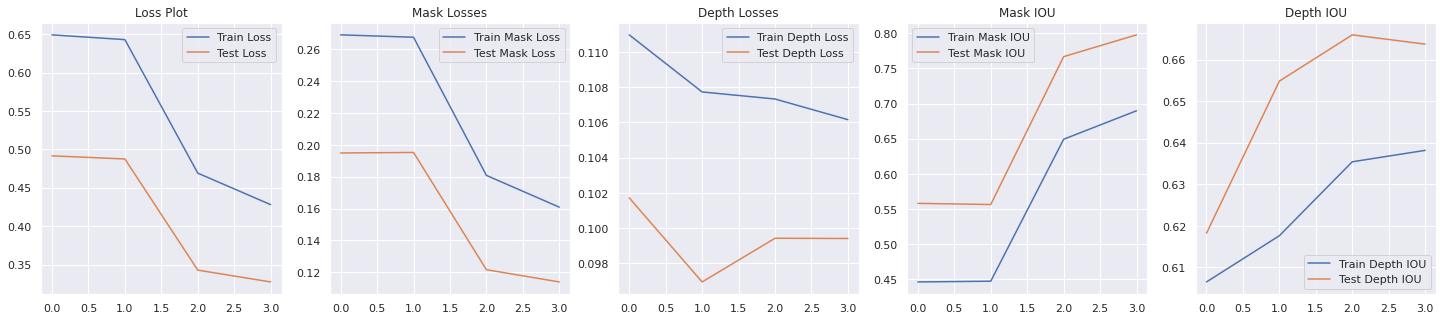

In [0]:
 
figure = plt.figure(figsize=(25,5))

plt.subplot(1,5,1)
plt.title("Loss Plot")
plt.plot(train_loss_all,label='Train Loss')
plt.plot(test_loss_all, label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,5,2)
plt.title("Mask Losses")
plt.plot(train_mask_loss_all,label='Train Mask Loss')
plt.plot(test_mask_loss_all, label='Test Mask Loss')
plt.legend(loc="best")

plt.subplot(1,5,3)
plt.title("Depth Losses")
plt.plot(train_depth_loss_all,label='Train Depth Loss')
plt.plot(test_depth_loss_all, label='Test Depth Loss')
plt.legend(loc="best")

plt.subplot(1,5,4)
plt.title("Mask IOU")
plt.plot(train_mask_iou_all,label='Train Mask IOU')
plt.plot(test_mask_iou_all, label='Test Mask IOU')
plt.legend(loc="best")

plt.subplot(1,5,5)
plt.title("Depth IOU")
plt.plot(train_depth_iou_all,label='Train Depth IOU')
plt.plot(test_depth_iou_all, label='Test Depth IOU')
plt.legend(loc="best")